#  **Brain Tumor Detection using Deep Learning**

By - Aditi Rawat and
     Bhanu Prasad Dharavathu

Abstract: Brain tumor detection from MRI scans is important for medical diagnosis.
This study uses three different deep learning methods to automatically detect tumors in brain images: a simple CNN, VGG16, and MobileNetV2.
We tested three approaches: (1) a CNN model; (2) VGG16, which uses knowledge from other image tasks; and (3) MobileNetV2, which is faster and uses less computing power.
All models were trained for 20 cycles to learn patterns in the images.
20 cycles to learn patterns in the images.

**Summary of the code**


**Data Preprocessing Pipeline**
•	Load 253 MRI images from Kaggle dataset (155 tumor, 98 no tumor)
•	Resize images to 224×224 pixels for model input
•	Convert BGR to RGB color format
•	Normalize pixel values to [0,1] range
•	Apply data augmentation (rotation, zoom, flipping)
•	Split data: 60% training, 20% validation, 20% test (stratified)
Model Development
**1. Custom CNN Architecture**
•	Conv2D layers with increasing filters (16→32→64)
•	MaxPooling2D layers for dimensionality reduction
•	Flatten layer + Dense layers (128→1 units)
•	Sigmoid activation for binary classification
•	Dropout (0.5) for regularization
**2. VGG16 Transfer Learning**
•	Load pre-trained VGG16 (ImageNet weights)
•	Freeze all base layers
•	Add custom classification head (GlobalAveragePooling2D + Dense layers)
•	Fine-tune with learning rate reduction
**3. MobileNetV2 Transfer Learning**
•	Load pre-trained MobileNetV2 (ImageNet weights)
•	Freeze base model initially
•	Add custom classification layers (GlobalAveragePooling2D → Dense → Dropout → Dense)
•	Fine-tune top layers gradually
Training Configuration
•	Optimizer: Adam
•	Loss function: Binary Cross-entropy
•	Metrics: Accuracy
•	Batch size: 16
•	Early stopping callback (patience=5)
•	Class weights to handle imbalance
**Evaluation Process**
•	Test on holdout set (51 images)
•	Generate confusion matrices
•	Calculate accuracy, precision, recall
•	Visualize training/validation curves
•	Compare model performances

**Key Results**
•	Simple CNN: 82.35% accuracy
•	VGG16: 78.43% accuracy
•	MobileNetV2: 84.31% accuracy (best performer)
•	MobileNetV2 showed best generalization with minimal false negatives

**Import the libraries**

In [ ]:
# Step 1: Import Required Libraries
# Import essential libraries for deep learning, image processing, and data handling
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import kagglehub

**Loading the dataset**

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Step 2: Download Dataset
# -----------------------
# Download brain tumor MRI dataset from Kaggle
print("Downloading brain tumor dataset...")
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /kaggle/input/brain-mri-images-for-brain-tumor-detection


**Structure of Dataset**

In [ ]:
# Step 3: Explore Dataset Structure
# --------------------------------
# Examine the dataset organization (two categories: yes/no tumor)
print("\nExamining dataset structure...")
categories = ['no', 'yes']  # no tumor, yes tumor

# Count images in each category
for category in categories:
    folder_path = os.path.join(path, category)
    num_images = len(os.listdir(folder_path))
    print(f"{category} tumor images: {num_images}")



Examining dataset structure...
no tumor images: 98
yes tumor images: 155


**Load and Preprocess Images**

In [ ]:
# Step 4: Load and Preprocess Images
# ---------------------------------
# Load images, convert to RGB, resize to 224x224, and normalize
def load_images(path):
    """Load and preprocess all images"""
    X = []  # Images
    y = []  # Labels

    for label, category in enumerate(categories):
        folder_path = os.path.join(path, category)
        print(f"\nLoading {category} images...")

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)

            # Read image in RGB format (required for pre-trained models)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize to standard size (224x224 for VGG16/MobileNetV2)
            img = cv2.resize(img, (224, 224))

            # Normalize pixel values to [0, 1]
            img = img / 255.0

            # Add to dataset
            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

**Data Visualization**


Loading no images...

Loading yes images...

Total images loaded: 253
Image shape: (224, 224, 3)


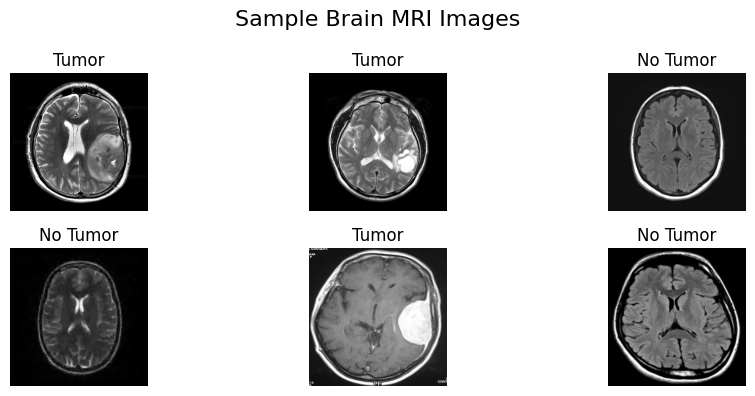

In [ ]:
# Step 5: Load All Images
# ----------------------
# Load all images and labels from the dataset
X, y = load_images(path)
print(f"\nTotal images loaded: {len(X)}")
print(f"Image shape: {X[0].shape}")

# Step 6: Visualize Sample Data
# ----------------------------
# Display sample images with their labels
plt.figure(figsize=(10, 4))
plt.suptitle('Sample Brain MRI Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 3, i+1)
    random_idx = np.random.randint(0, len(X))
    img = X[random_idx]
    label = 'Tumor' if y[random_idx] == 1 else 'No Tumor'

    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Split the Dataset**





In [ ]:
# Step 7: Split Dataset
# --------------------
# Split data into training (60%), validation (20%), and test (20%) sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42, stratify=y_train_temp)

print(f"\nDataset split:")
print(f"Training: {len(X_train)} images")
print(f"Validation: {len(X_val)} images")
print(f"Test: {len(X_test)} images")



Dataset split:
Training: 151 images
Validation: 51 images
Test: 51 images


**Model Building : CNN Model**

In [ ]:
def create_simple_cnn():
    """Create a simple CNN for brain tumor detection"""
    model = Sequential([
        # Simpler architecture for small dataset
        Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

**VGG16 Model(Transfer Learning)**

In [ ]:
# Step 9: Create VGG16 Model (Transfer Learning)
# ---------------------------------------------
def create_vgg16_model():
    """Create a VGG16-based model using transfer learning"""
    base_model = VGG16(input_shape=(224, 224, 3),
                       include_top=False,
                       weights='imagenet')

    # Keep all layers frozen for such a small dataset
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),  # Smaller dense layer
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

**MobileNetV2 Model(Transfer Learning)**

In [ ]:
# Step 10: Create MobileNetV2 Model (Transfer Learning)
# ---------------------------------------------------
# Use MobileNetV2 - lightweight and efficient architecture
def create_mobilenet_model():
    """Create a MobileNetV2-based model using transfer learning"""
    # Load MobileNetV2 without top layers, with pre-trained weights
    base_model = MobileNetV2(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')

    # Freeze base model layers
    base_model.trainable = False

    # Add custom classification layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

**Data Argumentation**

In [ ]:
# Updated data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False,
    zoom_range=0.05,
    brightness_range=[0.95, 1.05],
    fill_mode='nearest'
)

**Model Training**

In [ ]:
# Step 12: Train All Three Models
# ------------------------------
# Train each model and store their histories

# Step 12.0: Prepare Training Components
# --------------------------------------
# Learning rate callback

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Calculate class weights
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(y_train),
                                   y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Display class weights
print(f"Class weights: {class_weights_dict}")

# 12.1: Train Simple CNN
print("\n1. Training Simple CNN...")
cnn_model = create_simple_cnn()
cnn_model.summary()

# Use EarlyStopping instead of complex learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn_history = cnn_model.fit(X_train, y_train,
                          validation_data=(X_val, y_val),
                          epochs=50,
                          batch_size=16,
                          callbacks=[early_stop],
                          class_weight=class_weights_dict,
                          verbose=1)

# Rest of your code remains the same...
# 12.2: Train VGG16 Model
print("\n2. Training VGG16 Model...")
vgg16_model = create_vgg16_model()
vgg16_model.summary()

vgg16_history = vgg16_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=35,  # Increased from 20
                              batch_size=16,  # Changed from 32
                              callbacks=[reduce_lr],
                              class_weight=class_weights_dict,
                              verbose=1)

# 12.3: Train MobileNetV2 Model
print("\n3. Training MobileNetV2 Model...")
mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()

mobilenet_history = mobilenet_model.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      epochs=35,  # Increased from 20
                                      batch_size=16,  # Changed from 32
                                      callbacks=[reduce_lr],
                                      class_weight=class_weights_dict,
                                      verbose=1)

Class weights: {0: np.float64(1.3017241379310345), 1: np.float64(0.8118279569892473)}

1. Training Simple CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,561,633 (21.22 MB)

 Trainable params: 5,561,633 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - accuracy: 0.6689 - loss: 0.7844 - val_accuracy: 0.4902 - val_loss: 0.6785
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6765 - loss: 0.5699 - val_accuracy: 0.8824 - val_loss: 0.3448
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7958 - loss: 0.4473 - val_accuracy: 0.8824 - val_loss: 0.3315
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8716 - loss: 0.3655 - val_accuracy: 0.8824 - val_loss: 0.2649
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8693 - loss: 0.2300 - val_accuracy: 0.8824 - val_loss: 0.2737
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9036 - loss: 0.2608 - val_accuracy: 0.8627 - val_loss: 0.3285
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9029 - loss: 0.1846 - val_accuracy: 0.8235 - val_loss: 0.4068
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9696 - loss: 0.1433 - val_accuracy: 0.7647 -

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4690 - loss: 0.8253 - val_accuracy: 0.6471 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch 2/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5384 - loss: 0.6988 - val_accuracy: 0.8039 - val_loss: 0.5793 - learning_rate: 0.0010
Epoch 3/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6523 - loss: 0.6351 - val_accuracy: 0.6667 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 4/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6580 - loss: 0.5884 - val_accuracy: 0.7647 - val_loss: 0.5539 - learning_rate: 0.0010
Epoch 5/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6743 - loss: 0.5966 - val_accuracy: 0.8235 - val_loss: 0.5160 - learning_rate: 0.0010
Epoch 6/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7661 - loss: 0.5570 - val_accuracy: 0.8431 - val_loss: 0.4945 - learning_rate: 0.0010
Epoch 7/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.7492 - loss: 0.5365 - va

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,618,945 (9.99 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5699 - loss: 0.7069 - val_accuracy: 0.7647 - val_loss: 0.4526 - learning_rate: 0.0010
Epoch 2/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.7710 - loss: 0.4604 - val_accuracy: 0.9216 - val_loss: 0.2698 - learning_rate: 0.0010
Epoch 3/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7898 - loss: 0.4117 - val_accuracy: 0.8431 - val_loss: 0.3174 - learning_rate: 0.0010
Epoch 4/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8481 - loss: 0.3114 - val_accuracy: 0.9020 - val_loss: 0.2228 - learning_rate: 0.0010
Epoch 5/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8996 - loss: 0.2400 - val_accuracy: 0.9020 - val_loss: 0.1867 - learning_rate: 0.0010
Epoch 6/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8900 - loss: 0.1902 - val_accuracy: 0.9020 - val_loss: 0.2410 - learning_rate: 0.0010
Epoch 7/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9102 - loss: 0.2182 - val_acc

**Evaluate all the Models**



In [ ]:
# Step 13: Evaluate All Models
# ---------------------------
# Evaluate each model on the test set

# 13.1: Evaluate CNN
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"\nSimple CNN Test accuracy: {cnn_test_accuracy:.2%}")

# 13.2: Evaluate VGG16
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(X_test, y_test, verbose=0)
print(f"VGG16 Test accuracy: {vgg16_test_accuracy:.2%}")

# 13.3: Evaluate MobileNetV2
mobilenet_test_loss, mobilenet_test_accuracy = mobilenet_model.evaluate(X_test, y_test, verbose=0)
print(f"MobileNetV2 Test accuracy: {mobilenet_test_accuracy:.2%}")



Simple CNN Test accuracy: 80.39%
VGG16 Test accuracy: 76.47%
MobileNetV2 Test accuracy: 84.31%


**Visualize all the models**

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


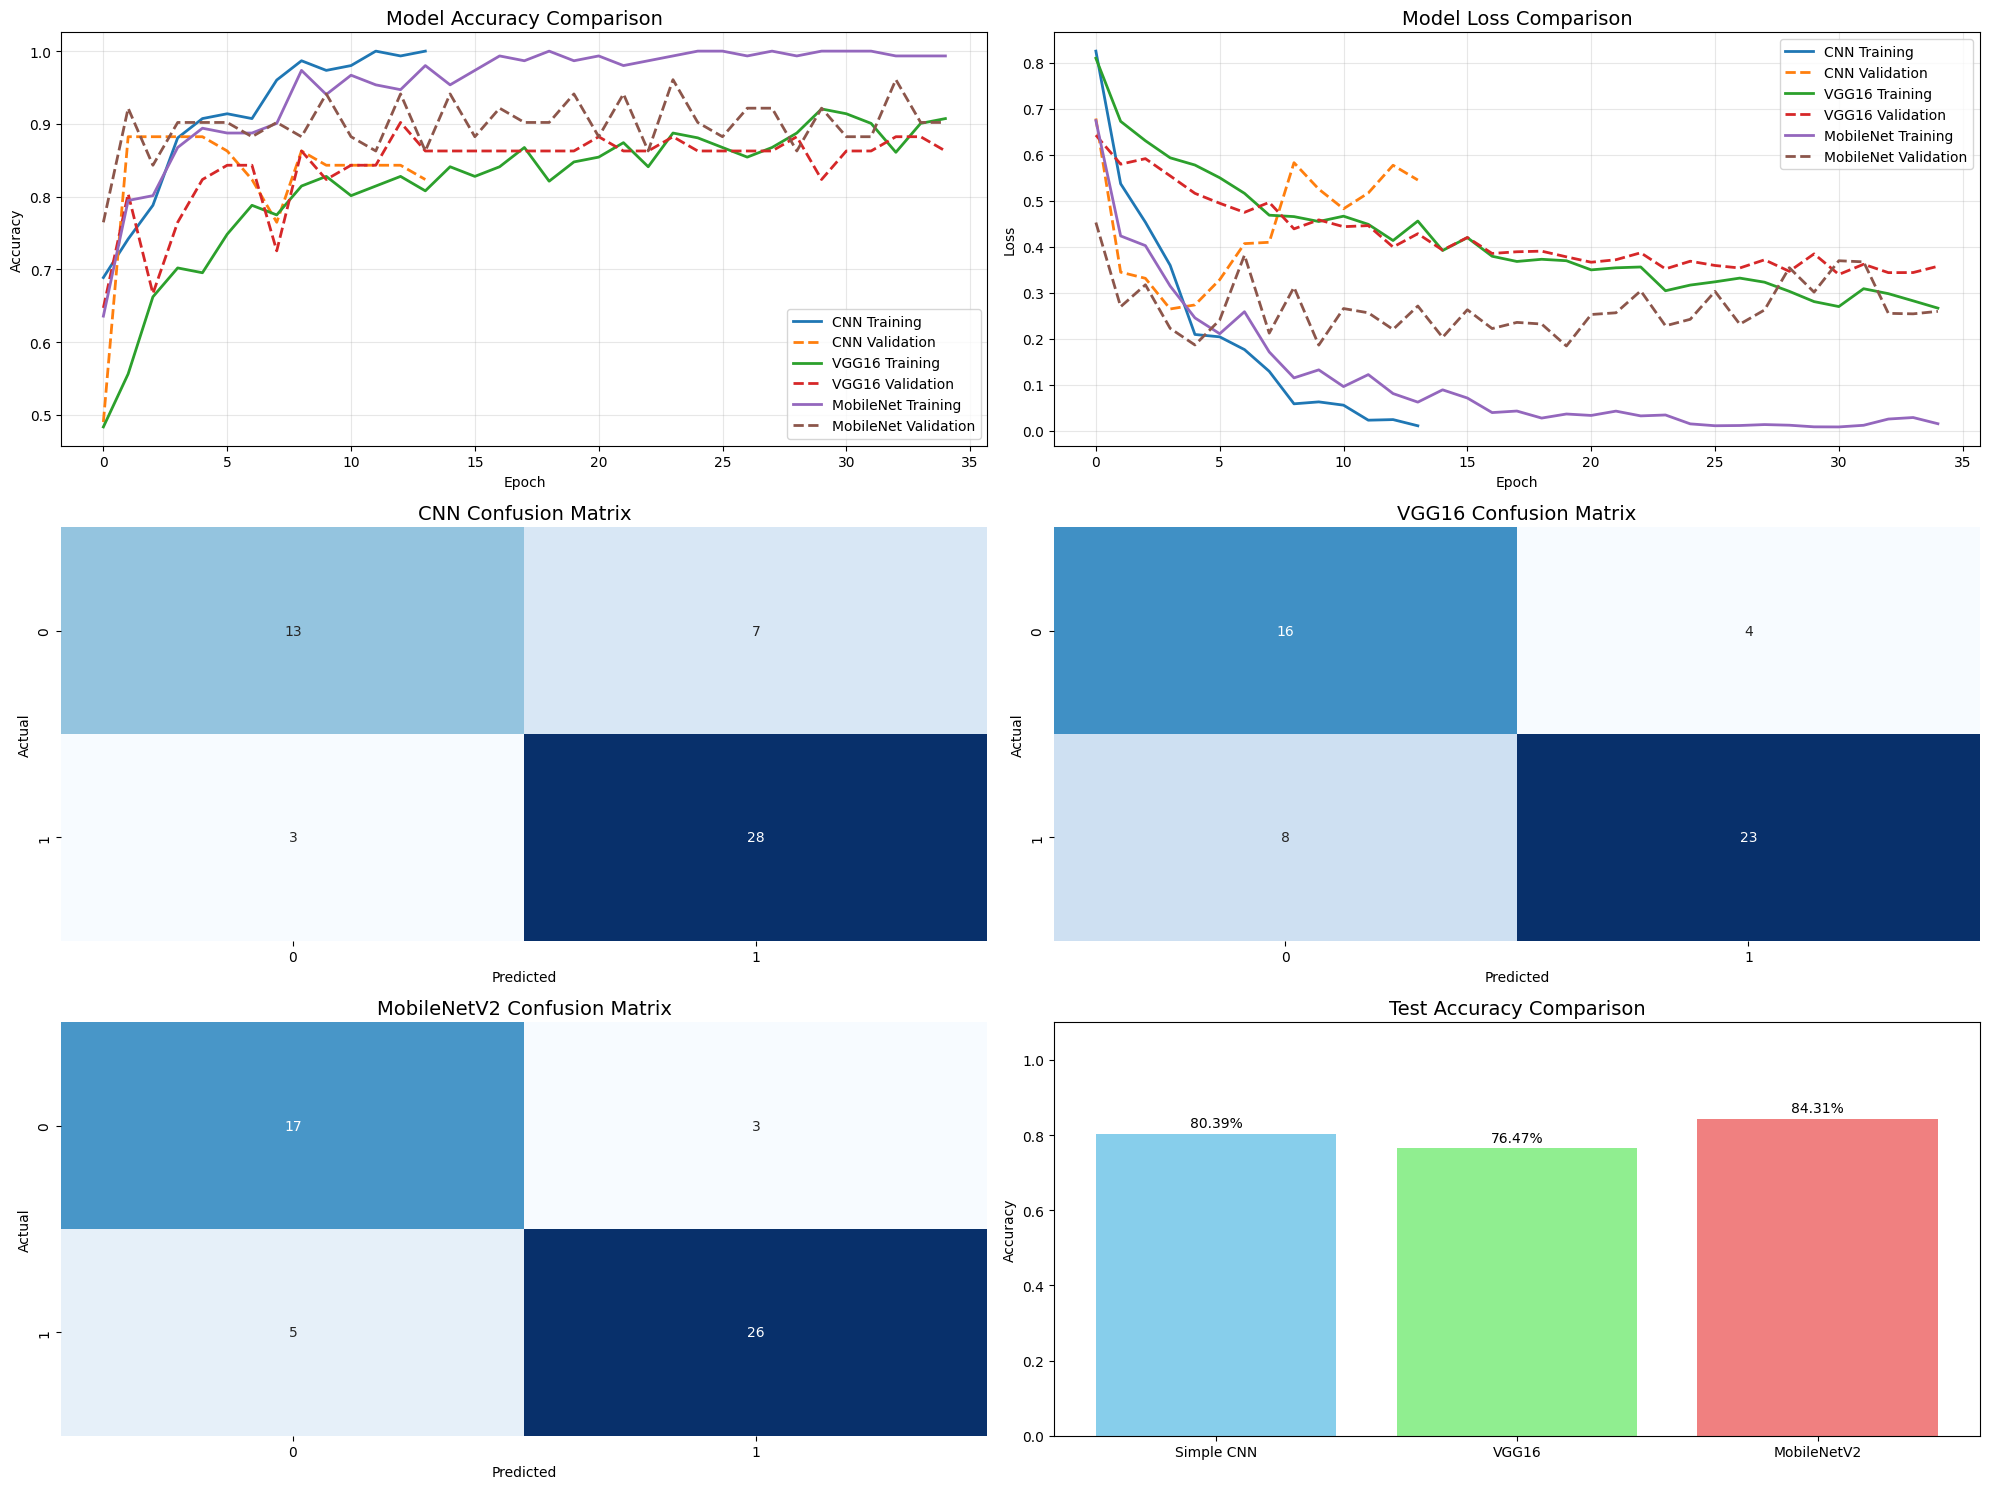

In [ ]:
# Step 14: Visualize Model Comparisons
# -----------------------------------
plt.figure(figsize=(20, 15))

# Plot 1: Training Accuracy Comparison
plt.subplot(3, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Training', linewidth=2)
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation', linewidth=2, linestyle='--')
plt.plot(vgg16_history.history['accuracy'], label='VGG16 Training', linewidth=2)
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16 Validation', linewidth=2, linestyle='--')
plt.plot(mobilenet_history.history['accuracy'], label='MobileNet Training', linewidth=2)
plt.plot(mobilenet_history.history['val_accuracy'], label='MobileNet Validation', linewidth=2, linestyle='--')
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Training Loss Comparison
plt.subplot(3, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Training', linewidth=2)
plt.plot(cnn_history.history['val_loss'], label='CNN Validation', linewidth=2, linestyle='--')
plt.plot(vgg16_history.history['loss'], label='VGG16 Training', linewidth=2)
plt.plot(vgg16_history.history['val_loss'], label='VGG16 Validation', linewidth=2, linestyle='--')
plt.plot(mobilenet_history.history['loss'], label='MobileNet Training', linewidth=2)
plt.plot(mobilenet_history.history['val_loss'], label='MobileNet Validation', linewidth=2, linestyle='--')
plt.title('Model Loss Comparison', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3-5: Confusion Matrices
cnn_pred = cnn_model.predict(X_test)
cnn_pred_binary = (cnn_pred > 0.5).astype(int)
cm_cnn = confusion_matrix(y_test, cnn_pred_binary)

vgg16_pred = vgg16_model.predict(X_test)
vgg16_pred_binary = (vgg16_pred > 0.5).astype(int)
cm_vgg16 = confusion_matrix(y_test, vgg16_pred_binary)

mobilenet_pred = mobilenet_model.predict(X_test)
mobilenet_pred_binary = (mobilenet_pred > 0.5).astype(int)
cm_mobilenet = confusion_matrix(y_test, mobilenet_pred_binary)

plt.subplot(3, 2, 3)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CNN Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(3, 2, 4)
sns.heatmap(cm_vgg16, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('VGG16 Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(3, 2, 5)
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('MobileNetV2 Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 6: Bar Chart of Test Accuracies
plt.subplot(3, 2, 6)
models = ['Simple CNN', 'VGG16', 'MobileNetV2']
accuracies = [cnn_test_accuracy, vgg16_test_accuracy, mobilenet_test_accuracy]
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Test Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Identify Best Model**

In [ ]:
# Step 15: Identify Best Model
# ---------------------------
# Compare all models and select the best performing one
accuracies_dict = {
    'Simple CNN': cnn_test_accuracy,
    'VGG16': vgg16_test_accuracy,
    'MobileNetV2': mobilenet_test_accuracy
}

best_model_name = max(accuracies_dict, key=accuracies_dict.get)
best_model = {
    'Simple CNN': cnn_model,
    'VGG16': vgg16_model,
    'MobileNetV2': mobilenet_model
}[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Best accuracy: {accuracies_dict[best_model_name]:.2%}")



Best performing model: MobileNetV2
Best accuracy: 84.31%


**To Create a Prediction Function**

In [ ]:
# Step 16: Create a Prediction Function
# --------------------------------------------
# Create a function that can use any of the trained models for prediction
def predict_tumor(image_path, model=None, model_name="Best"):
    """Predict if an image contains a brain tumor using the specified model"""
    if model is None:
        model = best_model

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = img.reshape(1, 224, 224, 3)

    # Make prediction
    prediction = model.predict(img)[0][0]

    # Interpret results
    if prediction > 0.5:
        result = f"Tumor detected (Confidence: {prediction:.2%})"
    else:
        result = f"No tumor detected (Confidence: {1-prediction:.2%})"

    return result, prediction

**Save the Models**

In [ ]:
# Step 17: Save All Models
# -----------------------
# Save each model for future use
cnn_model.save('brain_tumor_detector_cnn.keras')
vgg16_model.save('brain_tumor_detector_vgg16.keras')
mobilenet_model.save('brain_tumor_detector_mobilenet.keras')
best_model.save('brain_tumor_detector_best.keras')

print("\nAll models saved successfully!")



All models saved successfully!


**To demonstraste Predictions with all the models**


Testing all models on a sample image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


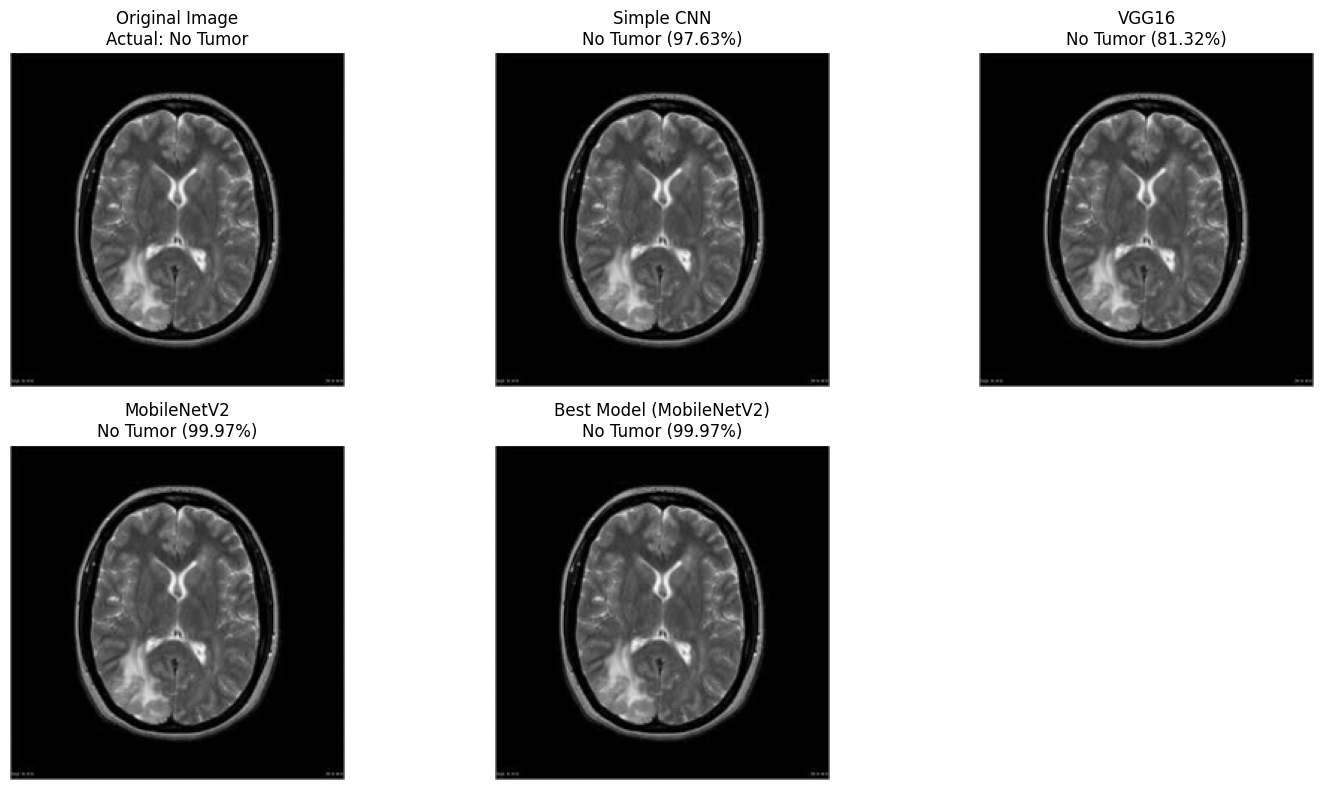

In [ ]:
# Step 18: To visualize Prediction with All Models
# ----------------------------------------------
# Test all models on a sample image
if len(X_test) > 0:
    print("\nTesting all models on a sample image...")
    test_idx = 0

    # Create visualization
    plt.figure(figsize=(15, 8))

    # Show original image
    plt.subplot(2, 3, 1)
    plt.imshow(X_test[test_idx])
    plt.title(f"Original Image\nActual: {'Tumor' if y_test[test_idx] == 1 else 'No Tumor'}", fontsize=12)
    plt.axis('off')

    # Test each model
    test_image = X_test[test_idx].reshape(1, 224, 224, 3)

    models_to_test = [
        (cnn_model, "Simple CNN"),
        (vgg16_model, "VGG16"),
        (mobilenet_model, "MobileNetV2"),
        (best_model, f"Best Model ({best_model_name})")
    ]

    for idx, (model, name) in enumerate(models_to_test[:4], 2):
        plt.subplot(2, 3, idx)
        plt.imshow(X_test[test_idx])

        prediction = model.predict(test_image)[0][0]
        label = "Tumor" if prediction > 0.5 else "No Tumor"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.title(f"{name}\n{label} ({confidence:.2%})", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

**Summary of Models**

In [ ]:
# Step 19: Final Summary
# ---------------------

print("\n" + "="*50)
print("BRAIN TUMOR DETECTION MODELS SUMMARY")
print("="*50)
print(f"\nDataset Information:")
print(f"- Total images: {len(X)}")
print(f"- Training images: {len(X_train)}")
print(f"- Validation images: {len(X_val)}")
print(f"- Test images: {len(X_test)}")

print(f"\nModel Performance:")
print(f"1. Simple CNN: {cnn_test_accuracy:.2%}")
print(f"2. VGG16 (Transfer Learning): {vgg16_test_accuracy:.2%}")
print(f"3. MobileNetV2 (Transfer Learning): {mobilenet_test_accuracy:.2%}")

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {accuracies_dict[best_model_name]:.2%}")

print("\nFiles Saved:")
print("- brain_tumor_detector_cnn.keras")
print("- brain_tumor_detector_vgg16.keras")
print("- brain_tumor_detector_mobilenet.keras")
print("- brain_tumor_detector_best.keras")


BRAIN TUMOR DETECTION MODELS SUMMARY

Dataset Information:
- Total images: 253
- Training images: 151
- Validation images: 51
- Test images: 51

Model Performance:
1. Simple CNN: 80.39%
2. VGG16 (Transfer Learning): 76.47%
3. MobileNetV2 (Transfer Learning): 84.31%

Best Model: MobileNetV2
Best Accuracy: 84.31%

Files Saved:
- brain_tumor_detector_cnn.keras
- brain_tumor_detector_vgg16.keras
- brain_tumor_detector_mobilenet.keras
- brain_tumor_detector_best.keras
